# Classifier on active, non-active users

In [325]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

dbname = 'mylocaldb' 
username = 'yangyang'

con = None
con = psycopg2.connect(database = dbname, user = username)

* Potential features
    * registered using FB?
    * signin_counts
    * provide address
    * item_wish_list, yes or no; how many are there?
    * gender
    * age

    * follow someone?
    * address or IP ? (5600+) later
    * provide measure? only provide when rent
    * provide fake info (phone, address)? later


In [326]:
sql_query = """
SELECT id, created_at, sign_in_count, email, phone, account_type, 
gender, country, zip, bust, waist,hips,height_feet,height_inches, date_of_birth
FROM users

"""
users = pd.read_sql_query(sql_query,con)
users.columns

Index(['id', 'created_at', 'sign_in_count', 'email', 'phone', 'account_type',
       'gender', 'country', 'zip', 'bust', 'waist', 'hips', 'height_feet',
       'height_inches', 'date_of_birth'],
      dtype='object')

In [327]:
sql_query = """
SELECT user_id, COUNT(item_id) as wish_items
FROM item_wishlists
GROUP BY user_id
"""
wish_items = pd.read_sql_query(sql_query,con)
wish_items.columns

Index(['user_id', 'wish_items'], dtype='object')

In [329]:
sql_query = """
SELECT renter_id, total_cost, created_at
FROM rentals
"""
rentals = pd.read_sql_query(sql_query,con)
rentals.columns

Index(['renter_id', 'total_cost', 'created_at'], dtype='object')

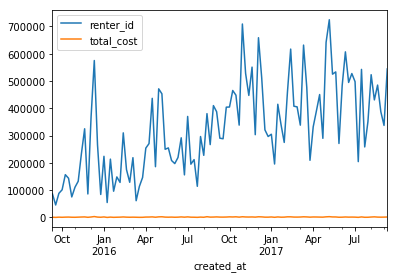

In [332]:
r = rentals.set_index(['created_at'])
r.resample('W').sum().plot()

In [231]:
sql_query = """
SELECT renter_id, total_cost
FROM rentals
"""
rentals = pd.read_sql_query(sql_query,con)
rentals.columns

Index(['renter_id', 'total_cost'], dtype='object')

In [305]:
df = pd.DataFrame(users.id)
df['sign_in_counts'] = users.sign_in_count
df['registerd_by_fb'] = users.account_type=='facebook'
df['provide_address'] = ~users.zip.isnull()
df = df.join(wish_items.set_index(['user_id']))
df['wish_items'] = ~df['wish_items'].isnull()
df_sex = pd.get_dummies(users['gender'].apply(
        lambda x: x if x in ['male','female'] else "Unknown_gender"))
df = pd.concat([df, df_sex],axis=1)

def get_age(x):
    try:
        d = pd.to_datetime('2017-09-14') - pd.to_datetime(x)
        return np.floor(d.days/365)
    except:
        return np.nan

age = users.date_of_birth.apply(get_age)
df['provide_age'] = ~age.isnull()
df['age'] = age.fillna(age.mean())

users['height'] = users.height_feet + users.height_inches/12
users.loc[users['height']<4,'height'] = np.nan

df['provide_height'] = ~users['height'].isnull()


# only select the users with more than half year with SL.

In [256]:
mask = users['created_at'] <pd.to_datetime('2017-03-14')
df = df[mask]

In [315]:
rental = rentals.dropna().groupby(['renter_id'])[['total_cost']].agg(['sum','count'])
rental.columns = ['total_cost','rent_time']
rental['renter_id'] = rental.index

Xy = pd.merge(df,rental,left_on='id',right_on='renter_id',how='left')
feature_columns = ['sign_in_counts','registerd_by_fb', 'provide_address',
       'wish_items', 'Unknown_gender', 'female', 'male', 'provide_age', 'age']
X = Xy[feature_columns]
y = ~Xy['total_cost'].isnull() # is the user becoming a renter

### Visualize the correlation between features


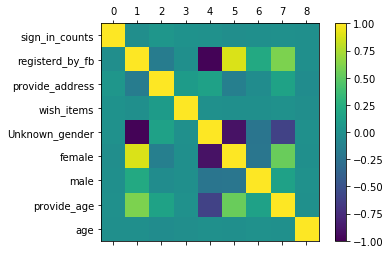

In [316]:
correlations = X.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(feature_columns)
plt.show()


In [333]:
X.columns

Index(['sign_in_counts', 'registerd_by_fb', 'provide_address', 'wish_items',
       'Unknown_gender', 'female', 'male', 'provide_age', 'age'],
      dtype='object')

In [317]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split

# le = LabelEncoder()
# rent_numeric = le.fit_transform(rent)

from sklearn.ensemble import RandomForestClassifier

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
model = RandomForestClassifier(n_estimators=1000, class_weight={0:1,1:100})
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)


In [318]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

      False       0.80      0.98      0.88      5481
       True       0.54      0.10      0.16      1474

avg / total       0.75      0.79      0.73      6955



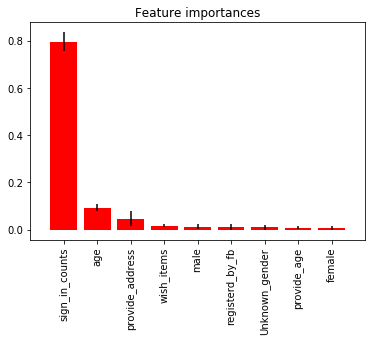

feature sign_in_counts: correlation w/ renter 0.179
feature age: correlation w/ renter -0.006
feature provide_address: correlation w/ renter 0.116
feature wish_items: correlation w/ renter 0.021
feature male: correlation w/ renter -0.040
feature registerd_by_fb: correlation w/ renter -0.068
feature Unknown_gender: correlation w/ renter 0.065
feature provide_age: correlation w/ renter -0.023
feature female: correlation w/ renter -0.048


In [324]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
ticks=[feature_columns[e] for e in indices]
plt.xticks(range(X.shape[1]),ticks,rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


for i in indices:
    print("feature {0}: correlation w/ renter {1:.3f}".format(feature_columns[i],
                                                              X[feature_columns[i]].corr(y)
        ))


In [320]:
from sklearn import metrics
from sklearn import svm
print(metrics.classification_report(ypred, ytest))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


classifier = svm.LinearSVC(random_state=0)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_score)


             precision    recall  f1-score   support

      False       0.80      0.98      0.88      5481
       True       0.54      0.10      0.16      1474

avg / total       0.75      0.79      0.73      6955



# Predict recurrent users

In [296]:
Xy.columns

Index(['id', 'sign_in_counts', 'registerd_by_fb', 'provide_address',
       'wish_items', 'Unknown_gender', 'female', 'male', 'provide_age', 'age',
       'bust', 'waist', 'hips', 'height', 'total_cost', 'rent_time',
       'renter_id'],
      dtype='object')

In [298]:
renter_mask = ~Xy['rent_time'].isnull()
feature_columns = ['sign_in_counts','registerd_by_fb', 'provide_address',
       'wish_items', 'Unknown_gender', 'female', 'male', 'provide_age', 'age', 'height']
X = Xy.loc[renter_mask,feature_columns]
y = Xy.loc[renter_mask,'rent_time']>1

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
model = RandomForestClassifier(n_estimators=1000, class_weight={0:1,1:100})
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print(metrics.classification_report(ypred, ytest))
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
ticks=[feature_columns[e] for e in indices]
plt.xticks(range(X.shape[1]),ticks,rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()